In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -qq /content/drive/MyDrive/PerfectGuide_ML/dataset/train.csv.zip

In [4]:
df = pd.read_csv('train.csv',encoding='latin-1')
print('dataset shape: ', df.shape, '\n\n')
print(df.info(),'\n\n')
print(df.columns,'\n\n')
df.head(3)

dataset shape:  (76020, 371) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB
None 


Index(['ID', 'var3', 'var15', 'imp_ent_var16_ult1', 'imp_op_var39_comer_ult1',
       'imp_op_var39_comer_ult3', 'imp_op_var40_comer_ult1',
       'imp_op_var40_comer_ult3', 'imp_op_var40_efect_ult1',
       'imp_op_var40_efect_ult3',
       ...
       'saldo_medio_var33_hace2', 'saldo_medio_var33_hace3',
       'saldo_medio_var33_ult1', 'saldo_medio_var33_ult3',
       'saldo_medio_var44_hace2', 'saldo_medio_var44_hace3',
       'saldo_medio_var44_ult1', 'saldo_medio_var44_ult3', 'var38', 'TARGET'],
      dtype='object', length=371) 




,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.0,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [5]:
print(df['TARGET'].value_counts())

unsatisfied_count = df[df['TARGET'] == 1]['TARGET'].count()
total_count = df['TARGET'].count()

print('\n Proportion of unsatisfied count = {0:.2f}'.format((unsatisfied_count/total_count)))

0    73012
1     3008
Name: TARGET, dtype: int64

 Proportion of unsatisfied count = 0.04


In [6]:
df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

In [7]:
# var3 컬럼이 평균과 중앙값의 차이가 너무 커서 상위 10개만 뽑아보기
print(df['var3'].value_counts()[:10])

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64


In [8]:
# var3 피처 값 대체 및 ID 피처 드롭
df['var3'].replace(-999999, 2, inplace=True)
df.drop('ID',axis=1 ,inplace=True)

In [9]:
# 피처 세트와 레이블 세트 분리, 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = df.iloc[:,:-1]
y_labels = df.iloc[:,-1]
print('피처 데이터 Shape {0}'.format(X_features.shape))

피처 데이터 Shape (76020, 369)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size = 0.2, random_state = 0)

train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape {0} , 테스트 세트 {1} '.format(X_train.shape, X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape (60816, 369) , 테스트 세트 (15204, 369) 
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로 설정
xgb_clf = XGBClassifier(n_estimators = 500, random_state = 156)

# 성능 평가 지표를 aucfh, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100,
            eval_metric='auc', eval_set = [(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average = 'macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

In [ ]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth' : [5, 7], 'min_child_weight' : [1,3], 'colsample_bytree' : [0.5, 0.75]}

# 하이퍼 파라미터 테스ㅡ의 수행속도를 향상시키기 위해 cv를 지정하지 않음.
gridcv = GridSearchCV(xgb_clf, param_grid = params)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc',
           eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_) 

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

In [ ]:
# n_estimators는 1000으로 증가시키고, learning_rate=0.02로 감소, reg_alpha=0.03으로 추가함. 
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=5,\
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, 
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

In [13]:
# reg_alpha=0.03으로 추가함. 
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.02, max_depth=7,\
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# evaluation metric을 auc로, early stopping은 200 으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=200, 
            eval_metric="auc",eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.82311	validation_1-auc:0.815226
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.827094	validation_1-auc:0.816566
[2]	validation_0-auc:0.832027	validation_1-auc:0.820393
[3]	validation_0-auc:0.835873	validation_1-auc:0.825019
[4]	validation_0-auc:0.838197	validation_1-auc:0.826078
[5]	validation_0-auc:0.837948	validation_1-auc:0.827282
[6]	validation_0-auc:0.8381	validation_1-auc:0.826888
[7]	validation_0-auc:0.838475	validation_1-auc:0.827131
[8]	validation_0-auc:0.839775	validation_1-auc:0.828198
[9]	validation_0-auc:0.83981	validation_1-auc:0.827834
[10]	validation_0-auc:0.841664	validation_1-auc:0.828996
[11]	validation_0-auc:0.841069	validation_1-auc:0.82802
[12]	validation_0-auc:0.841167	validation_1-auc:0.828517
[13]	validation_0-auc:0.841455	validation_1-auc:0.828317
[14]	validation_0-auc:0.845308	validation_1-auc:0.834099
[1

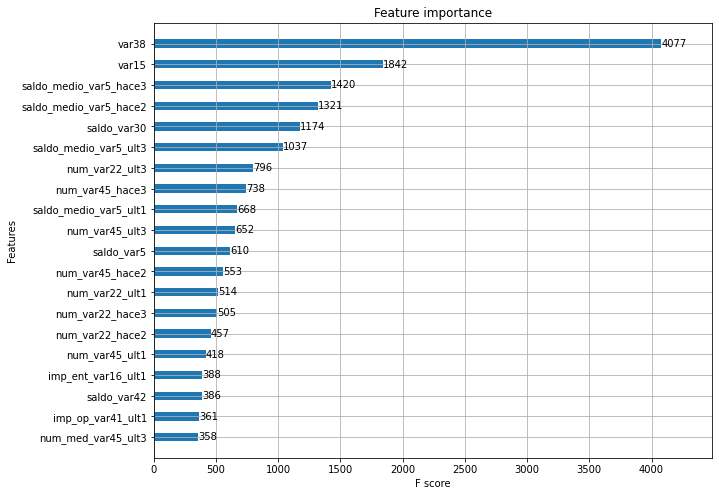

In [14]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

## LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [15]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="auc", eval_set=evals,
                verbose=True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.817384	valid_0's binary_logloss: 0.165046
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.81863	valid_0's binary_logloss: 0.16
[3]	valid_0's auc: 0.827411	valid_0's binary_logloss: 0.156287
[4]	valid_0's auc: 0.832175	valid_0's binary_logloss: 0.153416
[5]	valid_0's auc: 0.83481	valid_0's binary_logloss: 0.151206
[6]	valid_0's auc: 0.834721	valid_0's binary_logloss: 0.149303
[7]	valid_0's auc: 0.83659	valid_0's binary_logloss: 0.147804
[8]	valid_0's auc: 0.837602	valid_0's binary_logloss: 0.146466
[9]	valid_0's auc: 0.838114	valid_0's binary_logloss: 0.145476
[10]	valid_0's auc: 0.838472	valid_0's binary_logloss: 0.144681
[11]	valid_0's auc: 0.83808	valid_0's binary_logloss: 0.143978
[12]	valid_0's auc: 0.837771	valid_0's binary_logloss: 0.14341
[13]	valid_0's auc: 0.838063	valid_0's binary_logloss: 0.142835
[14]	valid_0's auc: 0.838485	valid_0's binary_logloss: 0.142296
[15]	valid_0's auc: 0.838542	valid_0's binary_logloss: 0.14

In [17]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
LGBM_clf = LGBMClassifier(n_estimators=200)

params = {'num_leaves' : [32, 54],
         'max_depth':[128, 160],
          'min_child_samples' : [60, 100],
          'subsample' : [0.8, 1]}

# 하이퍼 파라미터 테스트의 수행속도를 향상 시키기 위해 cv를 지정하지 않음.
gridcv = GridSearchCV(lgbm_clf, param_grid=params)
gridcv.fit(X_train, y_train, early_stopping_rounds = 30, eval_metric = 'auc',
           eval_set = [(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터 : ', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198	valid_1's auc: 0.821078	valid_1's binary_logloss: 0.16488
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.82965	valid_0's binary_logloss: 0.15092	valid_1's auc: 0.824865	valid_1's binary_logloss: 0.15978
[3]	valid_0's auc: 0.835112	valid_0's binary_logloss: 0.147151	valid_1's auc: 0.826157	valid_1's binary_logloss: 0.156174
[4]	valid_0's auc: 0.839678	valid_0's binary_logloss: 0.14422	valid_1's auc: 0.830489	valid_1's binary_logloss: 0.153395
[5]	valid_0's auc: 0.842477	valid_0's binary_logloss: 0.141762	valid_1's auc: 0.832915	valid_1's binary_logloss: 0.151083
[6]	valid_0's auc: 0.845763	valid_0's binary_logloss: 0.139668	valid_1's auc: 0.835313	valid_1's binary_logloss: 0.149317
[7]	valid_0's auc: 0.846352	valid_0's binary_logloss: 0.137997	valid_1's auc: 0.835977	valid_1's binary_logloss: 0.14773
[8]	valid_0's auc: 0.849153	valid_0's binary_logloss: 0.13653	valid_1's auc: 0.837152	vali

In [18]:
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves=32, sumbsample = 0.8, min_child_samples = 100,
                          max_depth = 128)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, early_stopping_rounds = 100, eval_metric = 'auc', eval_set = evals,
             verbose = True)

lgbm_roc_score = roc_auc_score(y_test,
                               lgbm_clf.predict_proba(X_test)[:,1],
                               average = 'macro')
print('ROC AUC : {0:.4f}'.format(lgbm_roc_score))

[1]	valid_0's auc: 0.819488	valid_0's binary_logloss: 0.165016
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.822387	valid_0's binary_logloss: 0.159711
[3]	valid_0's auc: 0.829542	valid_0's binary_logloss: 0.156068
[4]	valid_0's auc: 0.834917	valid_0's binary_logloss: 0.153141
[5]	valid_0's auc: 0.837871	valid_0's binary_logloss: 0.150804
[6]	valid_0's auc: 0.839548	valid_0's binary_logloss: 0.148876
[7]	valid_0's auc: 0.841812	valid_0's binary_logloss: 0.147225
[8]	valid_0's auc: 0.842382	valid_0's binary_logloss: 0.14594
[9]	valid_0's auc: 0.842811	valid_0's binary_logloss: 0.144866
[10]	valid_0's auc: 0.843186	valid_0's binary_logloss: 0.143872
[11]	valid_0's auc: 0.843465	valid_0's binary_logloss: 0.14305
[12]	valid_0's auc: 0.843222	valid_0's binary_logloss: 0.142376
[13]	valid_0's auc: 0.843564	valid_0's binary_logloss: 0.141783
[14]	valid_0's auc: 0.843389	valid_0's binary_logloss: 0.141419
[15]	valid_0's auc: 0.84365	valid_0's binary_logloss